# 🎯 05. 제품 추천 시스템 (Product Recommendation System)

---

## 📚 이번 노트북에서 배울 내용

### 1. **추천 시스템이란?**
- 추천 시스템은 사용자가 좋아할 만한 상품, 영화, 음악 등을 예측해서 추천해주는 기술입니다
- 예시:
  - Netflix가 영화를 추천해주는 것
  - YouTube가 동영상을 추천해주는 것
  - Amazon이 상품을 추천해주는 것
  - Spotify가 음악을 추천해주는 것

### 2. **추천 시스템의 종류**
- **콘텐츠 기반 필터링 (Content-Based Filtering)**
  - 제품의 특성(가격, 카테고리, 성분 등)을 분석해서 비슷한 제품을 추천
  - 예: "이 보습 크림과 비슷한 성분의 다른 크림 추천"
  
- **협업 필터링 (Collaborative Filtering)**
  - 비슷한 취향을 가진 사용자들의 선택을 바탕으로 추천
  - 예: "나와 비슷한 피부 타입을 가진 사람들이 좋아한 제품 추천"

### 3. **이번 노트북에서 구현할 추천 시스템**
1. **제품 유사도 기반 추천**: 특정 제품과 비슷한 제품 찾기
2. **피부 타입 기반 추천**: 내 피부 타입에 맞는 인기 제품 찾기
3. **브랜드 기반 추천**: 특정 브랜드의 인기 제품 추천
4. **카테고리 & 가격대 기반 추천**: 원하는 가격대의 제품 추천

---

## 🎓 핵심 개념

### **코사인 유사도 (Cosine Similarity)**
- 두 개의 벡터(숫자 배열) 사이의 유사도를 측정하는 방법
- 값의 범위: -1 ~ 1
  - 1에 가까울수록: 매우 유사함
  - 0에 가까울수록: 관련 없음
  - -1에 가까울수록: 정반대
- 예시: 
  - 제품 A = [가격: 50, 평점: 4.5, 리뷰수: 1000]
  - 제품 B = [가격: 55, 평점: 4.3, 리뷰수: 950]
  - → 두 제품은 매우 유사함!

### **TF-IDF (Term Frequency-Inverse Document Frequency)**
- 텍스트에서 중요한 단어를 찾아내는 방법
- 자주 등장하지만 모든 문서에 나오는 단어(예: "the", "a")는 중요도가 낮음
- 특정 문서에만 자주 나오는 단어(예: "hyaluronic acid")는 중요도가 높음

---

## 1️⃣ 라이브러리 불러오기 및 데이터 로드

---

In [1]:
# ============================================================
# 필요한 라이브러리 불러오기
# ============================================================

# 데이터 처리 라이브러리
import pandas as pd  # 데이터를 표(테이블) 형태로 다루는 라이브러리
import numpy as np   # 수치 계산을 빠르게 해주는 라이브러리

# 시각화 라이브러리
import matplotlib.pyplot as plt  # 그래프를 그리는 기본 라이브러리
import seaborn as sns            # matplotlib을 더 예쁘게 만들어주는 라이브러리

# 경고 메시지 숨기기 (코드 실행 시 불필요한 경고를 보지 않기 위함)
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (그래프에 한글이 깨지지 않도록)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows의 경우
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# ============================================================
# 추천 시스템에 필요한 특별한 라이브러리
# ============================================================

# 텍스트를 숫자로 변환하는 라이브러리 (제품 설명, 성분 등을 분석)
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizer: 텍스트를 중요도가 반영된 숫자 벡터로 변환

# 유사도를 계산하는 라이브러리
from sklearn.metrics.pairwise import cosine_similarity
# cosine_similarity: 두 벡터(숫자 배열) 사이의 유사도를 0~1 사이의 값으로 계산
# 1에 가까울수록 매우 유사, 0에 가까울수록 관련 없음

# 데이터 스케일링 (정규화)
from sklearn.preprocessing import StandardScaler
# StandardScaler: 데이터의 평균을 0, 표준편차를 1로 만들어 스케일 조정
# 가격(0~500)과 평점(0~5)처럼 범위가 다른 데이터를 비교 가능하게 만듦

print("✅ 모든 라이브러리를 성공적으로 불러왔습니다!")
print("="*60)

✅ 모든 라이브러리를 성공적으로 불러왔습니다!


In [2]:
# ============================================================
# 전처리된 데이터 불러오기
# ============================================================
# 01_data_preprocessing.ipynb에서 만든 전처리된 데이터를 불러옵니다

# 제품 데이터 불러오기
print("📂 제품 데이터를 불러오는 중...")
products_df = pd.read_csv('cleaned_products.csv')
print(f"   ✅ 제품 데이터 로드 완료: {len(products_df):,}개 제품")

# 리뷰 데이터 불러오기
print("\n📂 리뷰 데이터를 불러오는 중...")
reviews_df = pd.read_csv('cleaned_reviews.csv')
print(f"   ✅ 리뷰 데이터 로드 완료: {len(reviews_df):,}개 리뷰")

print("="*60)

# ============================================================
# 데이터 미리보기
# ============================================================

print("\n📊 제품 데이터 미리보기 (처음 3개 제품):")
print("-"*60)
# 중요한 컬럼만 선택해서 보기
display_cols = ['product_name', 'brand_name', 'price_usd', 'rating', 'reviews', 'primary_category']
print(products_df[display_cols].head(3))

print("\n📊 리뷰 데이터 미리보기 (처음 3개 리뷰):")
print("-"*60)
# 중요한 컬럼만 선택해서 보기
review_cols = ['product_id', 'rating', 'is_recommended', 'skin_type', 'review_text']
print(reviews_df[review_cols].head(3))

print("="*60)

📂 제품 데이터를 불러오는 중...
   ✅ 제품 데이터 로드 완료: 8,494개 제품

📂 리뷰 데이터를 불러오는 중...
   ✅ 리뷰 데이터 로드 완료: 1,092,966개 리뷰

📊 제품 데이터 미리보기 (처음 3개 제품):
------------------------------------------------------------
                product_name brand_name  price_usd  rating  reviews  \
0    Fragrance Discovery Set      19-69       35.0  3.6364       11   
1    La Habana Eau de Parfum      19-69      195.0  4.1538       13   
2  Rainbow Bar Eau de Parfum      19-69      195.0  4.2500       16   

  primary_category  
0        Fragrance  
1        Fragrance  
2        Fragrance  

📊 리뷰 데이터 미리보기 (처음 3개 리뷰):
------------------------------------------------------------
  product_id  rating  is_recommended skin_type  \
0    P504322       5            True       dry   
1    P420652       1           False   unknown   
2    P420652       5            True       dry   

                                         review_text  
0  I use this with the Nudestix “Citrus Clean Bal...  
1  I bought this lip mask after reading t

## 2️⃣ 추천 시스템 1: 제품 유사도 기반 추천

---

### 🎯 목표
- 특정 제품과 비슷한 다른 제품을 찾아서 추천하기
- 예: "Estée Lauder Advanced Night Repair"와 비슷한 세럼 추천

### 🔍 방법
1. 제품의 특성(브랜드, 카테고리, 가격, 성분 등)을 숫자로 변환
2. 코사인 유사도를 이용해 제품 간 유사도 계산
3. 유사도가 높은 제품들을 추천

---

In [3]:
# ============================================================
# 2-1. 제품 특성을 하나의 텍스트로 결합하기
# ============================================================
# 추천 시스템을 만들기 위해 제품의 여러 특성을 하나의 텍스트로 합칩니다
# 예: "Skincare Moisturizer Dry DrBarbaraStrurm hydrating cream luxury"

print("🔧 제품 특성을 텍스트로 결합하는 중...\n")

# 결측값을 빈 문자열로 대체 (NaN이 있으면 결합할 때 오류 발생)
products_df['brand_name'] = products_df['brand_name'].fillna('')
products_df['primary_category'] = products_df['primary_category'].fillna('')
products_df['secondary_category'] = products_df['secondary_category'].fillna('')
products_df['tertiary_category'] = products_df['tertiary_category'].fillna('')
products_df['highlights'] = products_df['highlights'].fillna('')
products_df['ingredients'] = products_df['ingredients'].fillna('')

# 여러 특성을 하나의 텍스트로 결합
# 각 특성을 공백으로 연결하여 하나의 문자열 생성
products_df['combined_features'] = (
    products_df['primary_category'] + ' ' +          # 주요 카테고리 (예: "Skincare")
    products_df['secondary_category'] + ' ' +        # 보조 카테고리 (예: "Moisturizer")
    products_df['tertiary_category'] + ' ' +         # 세부 카테고리 (예: "Face Moisturizer")
    products_df['brand_name'] + ' ' +                # 브랜드 이름 (예: "Estée Lauder")
    products_df['highlights'] + ' ' +                # 제품 특징 (예: "Hydrating, Anti-aging")
    products_df['ingredients']                       # 성분 (예: "Hyaluronic Acid, Vitamin C")
)

# 소문자로 변환하여 일관성 유지 ("Skincare"와 "skincare"를 같게 처리)
products_df['combined_features'] = products_df['combined_features'].str.lower()

# 공백 제거 (불필요한 여러 개의 공백을 하나로)
products_df['combined_features'] = products_df['combined_features'].str.strip()

# 결과 확인
print("✅ 제품 특성 결합 완료!\n")
print("📊 결합된 특성 예시 (처음 3개 제품):\n")
for idx in range(3):
    product_name = products_df.iloc[idx]['product_name']
    combined = products_df.iloc[idx]['combined_features'][:150]  # 처음 150자만 출력
    print(f"{idx+1}. {product_name}")
    print(f"   결합된 특성: {combined}...\n")

print("="*60)

🔧 제품 특성을 텍스트로 결합하는 중...

✅ 제품 특성 결합 완료!

📊 결합된 특성 예시 (처음 3개 제품):

1. Fragrance Discovery Set
   결합된 특성: fragrance value & gift sets perfume gift sets 19-69 ['unisex/ genderless scent', 'warm &spicy scent', 'woody & earthy scent', 'fresh scent'] ['capri e...

2. La Habana Eau de Parfum
   결합된 특성: fragrance women perfume 19-69 ['unisex/ genderless scent', 'layerable scent', 'warm &spicy scent'] ['alcohol denat. (sd alcohol 39c), parfum (fragranc...

3. Rainbow Bar Eau de Parfum
   결합된 특성: fragrance women perfume 19-69 ['unisex/ genderless scent', 'layerable scent', 'woody & earthy scent'] ['alcohol denat. (sd alcohol 39c), parfum (fragr...



In [4]:
# ============================================================
# 2-2. TF-IDF 벡터화 (텍스트를 숫자로 변환)
# ============================================================
# TF-IDF는 텍스트에서 중요한 단어를 찾아내고, 각 단어의 중요도를 숫자로 표현합니다

print("🔧 TF-IDF 벡터화를 시작합니다...\n")

# TF-IDF Vectorizer 객체 생성
tfidf = TfidfVectorizer(
    max_features=1000,      # 가장 중요한 단어 1000개만 사용 (메모리 절약)
    stop_words='english',   # 영어 불용어 제거 ("the", "is", "and" 등)
    ngram_range=(1, 2)      # 1개 단어와 2개 연속 단어 조합 모두 사용
                            # 예: "hyaluronic" (1-gram), "hyaluronic acid" (2-gram)
)

# TF-IDF 변환 수행
# 텍스트 → 숫자 행렬 변환
# 결과는 (제품 수 x 단어 수) 크기의 희소 행렬(sparse matrix)
tfidf_matrix = tfidf.fit_transform(products_df['combined_features'])

print(f"✅ TF-IDF 벡터화 완료!")
print(f"   - 행렬 크기: {tfidf_matrix.shape}")
print(f"   - 의미: {tfidf_matrix.shape[0]:,}개 제품 x {tfidf_matrix.shape[1]:,}개 단어 특성")
print(f"   - 각 제품이 {tfidf_matrix.shape[1]:,}개의 숫자로 표현됩니다\n")

# 중요한 단어(특성) 몇 개 출력해보기
feature_names = tfidf.get_feature_names_out()
print(f"📊 추출된 중요 특성(단어) 예시 (처음 20개):\n")
print(feature_names[:20])

print("\n" + "="*60)

🔧 TF-IDF 벡터화를 시작합니다...

✅ TF-IDF 벡터화 완료!
   - 행렬 크기: (8494, 1000)
   - 의미: 8,494개 제품 x 1,000개 단어 특성
   - 각 제품이 1,000개의 숫자로 표현됩니다

📊 추출된 중요 특성(단어) 예시 (처음 20개):

['10' '10 dimethicone' '100' '100 stearate' '11' '12' '14' '14700'
 '14700 red' '15' '15 alkyl' '15850' '15850 red' '15985' '16' '17200' '18'
 '19140' '19140 yellow' '20']



In [5]:
# ============================================================
# 2-3. 코사인 유사도 계산
# ============================================================
# 모든 제품 간의 유사도를 계산합니다
# 결과는 (제품 수 x 제품 수) 크기의 유사도 행렬

print("🔧 코사인 유사도를 계산하는 중...\n")
print("⚠️  데이터가 많으면 시간이 걸릴 수 있습니다. 잠시만 기다려주세요...\n")

# 코사인 유사도 계산
# cosine_similarity(A, B)는 A의 각 행과 B의 각 행 사이의 유사도를 계산
# 같은 행렬을 두 번 넣으면 모든 제품 쌍 사이의 유사도가 계산됨
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print(f"✅ 유사도 계산 완료!")
print(f"   - 유사도 행렬 크기: {cosine_sim.shape}")
print(f"   - 의미: {cosine_sim.shape[0]:,}개 제품 x {cosine_sim.shape[0]:,}개 제품")
print(f"   - 각 제품과 다른 모든 제품 간의 유사도가 저장되어 있습니다\n")

# 유사도 행렬 예시 (처음 5x5 부분만)
print("📊 유사도 행렬 예시 (처음 5개 제품 간 유사도):\n")
print("   값이 1에 가까울수록 매우 유사한 제품입니다")
print("   대각선은 자기 자신과의 유사도이므로 항상 1.0입니다\n")
print(pd.DataFrame(cosine_sim[:5, :5], 
                   columns=[f'제품{i+1}' for i in range(5)],
                   index=[f'제품{i+1}' for i in range(5)]).round(3))

print("\n" + "="*60)

🔧 코사인 유사도를 계산하는 중...

⚠️  데이터가 많으면 시간이 걸릴 수 있습니다. 잠시만 기다려주세요...

✅ 유사도 계산 완료!
   - 유사도 행렬 크기: (8494, 8494)
   - 의미: 8,494개 제품 x 8,494개 제품
   - 각 제품과 다른 모든 제품 간의 유사도가 저장되어 있습니다

📊 유사도 행렬 예시 (처음 5개 제품 간 유사도):

   값이 1에 가까울수록 매우 유사한 제품입니다
   대각선은 자기 자신과의 유사도이므로 항상 1.0입니다

       제품1    제품2    제품3    제품4    제품5
제품1  1.000  0.743  0.718  0.718  0.713
제품2  0.743  1.000  0.822  0.853  0.828
제품3  0.718  0.822  1.000  0.931  0.932
제품4  0.718  0.853  0.931  1.000  0.925
제품5  0.713  0.828  0.932  0.925  1.000



In [6]:
# ============================================================
# 2-4. 추천 함수 만들기
# ============================================================
# 제품 이름을 입력하면 유사한 제품 10개를 추천해주는 함수

def get_product_recommendations(product_name, top_n=10):
    """
    제품 이름을 기반으로 유사한 제품을 추천하는 함수
    
    Parameters:
    -----------
    product_name : str
        추천받고 싶은 제품의 이름 (정확한 이름이 아니어도 부분 매칭 가능)
    top_n : int
        추천받을 제품의 개수 (기본값: 10)
    
    Returns:
    --------
    DataFrame
        추천 제품 목록 (제품명, 브랜드, 가격, 평점, 유사도 점수 포함)
    """
    
    # 1단계: 입력한 제품명으로 제품 찾기
    # 정확한 이름이 아니어도 부분적으로 일치하는 제품 찾기 (대소문자 구분 없음)
    matching_products = products_df[products_df['product_name'].str.contains(product_name, case=False, na=False)]
    
    # 제품을 찾지 못한 경우
    if len(matching_products) == 0:
        print(f"❌ '{product_name}'와 일치하는 제품을 찾을 수 없습니다.")
        print("   제품 이름을 다시 확인해주세요.")
        return None
    
    # 여러 제품이 매칭된 경우, 첫 번째 제품 사용
    if len(matching_products) > 1:
        print(f"⚠️  '{product_name}'와 일치하는 제품이 {len(matching_products)}개 있습니다.")
        print("   첫 번째 제품을 기준으로 추천합니다.\n")
    
    # 2단계: 선택된 제품의 인덱스 가져오기
    product_idx = matching_products.index[0]
    selected_product = products_df.iloc[product_idx]
    
    print(f"🎯 선택된 제품 정보:")
    print(f"   제품명: {selected_product['product_name']}")
    print(f"   브랜드: {selected_product['brand_name']}")
    print(f"   가격: ${selected_product['price_usd']:.2f}")
    print(f"   평점: {selected_product['rating']:.1f}/5.0")
    print(f"   카테고리: {selected_product['primary_category']}\n")
    
    # 3단계: 이 제품과 다른 모든 제품 간의 유사도 가져오기
    similarity_scores = list(enumerate(cosine_sim[product_idx]))
    # enumerate(): (인덱스, 값) 형태의 튜플 리스트 생성
    # 예: [(0, 0.95), (1, 0.87), (2, 0.92), ...]
    
    # 4단계: 유사도 점수를 기준으로 내림차순 정렬
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    # lambda x: x[1] → 각 튜플의 두 번째 요소(유사도 점수)를 기준으로 정렬
    # reverse=True → 내림차순 (높은 유사도부터)
    
    # 5단계: 가장 유사한 제품들의 인덱스 가져오기
    # [1:top_n+1]을 사용하는 이유: 첫 번째는 자기 자신(유사도 1.0)이므로 제외
    top_indices = [i[0] for i in similarity_scores[1:top_n+1]]
    top_scores = [i[1] for i in similarity_scores[1:top_n+1]]
    
    # 6단계: 추천 제품 정보 가져오기
    recommendations = products_df.iloc[top_indices].copy()
    recommendations['similarity_score'] = top_scores
    
    # 7단계: 필요한 컬럼만 선택하여 반환
    result = recommendations[[
        'product_name', 'brand_name', 'price_usd', 'rating', 
        'reviews', 'primary_category', 'similarity_score'
    ]]
    
    return result

print("✅ 추천 함수 생성 완료!")
print("="*60)

✅ 추천 함수 생성 완료!


In [7]:
# ============================================================
# 2-5. 추천 시스템 테스트
# ============================================================
# 실제로 제품을 추천받아 봅시다!

print("\n" + "="*60)
print("🎁 제품 추천 시스템 테스트")
print("="*60 + "\n")

# 예시 1: "Moisturizer" 검색
print("\n📌 예시 1: 'Moisturizer'라는 단어가 포함된 제품 추천\n")
print("-"*60 + "\n")
recommendations_1 = get_product_recommendations('Moisturizer', top_n=5)

if recommendations_1 is not None:
    print("\n🎁 추천 제품 목록:\n")
    for idx, row in recommendations_1.iterrows():
        print(f"{recommendations_1.index.get_loc(idx)+1}. {row['product_name']}")
        print(f"   브랜드: {row['brand_name']}")
        print(f"   가격: ${row['price_usd']:.2f} | 평점: {row['rating']:.1f}/5.0")
        print(f"   유사도: {row['similarity_score']:.3f} (1.0에 가까울수록 유사)\n")

print("\n" + "="*60)


🎁 제품 추천 시스템 테스트


📌 예시 1: 'Moisturizer'라는 단어가 포함된 제품 추천

------------------------------------------------------------

⚠️  'Moisturizer'와 일치하는 제품이 290개 있습니다.
   첫 번째 제품을 기준으로 추천합니다.

🎯 선택된 제품 정보:
   제품명: GENIUS Sleeping Collagen Moisturizer
   브랜드: Algenist
   가격: $98.00
   평점: 4.5/5.0
   카테고리: Skincare


🎁 추천 제품 목록:

1. After-Dark Natural Peptide Sleeping Cream
   브랜드: Naturally Serious
   가격: $37.00 | 평점: 4.4/5.0
   유사도: 0.535 (1.0에 가까울수록 유사)

2. Nourishing Squalane Daily Moisturizer
   브랜드: The Outset
   가격: $44.00 | 평점: 4.6/5.0
   유사도: 0.507 (1.0에 가까울수록 유사)

3. GOOPGENES All-In-One Nourishing Face Cream
   브랜드: goop
   가격: $98.00 | 평점: 4.3/5.0
   유사도: 0.502 (1.0에 가까울수록 유사)

4. Squalane + Retinol Night Serum
   브랜드: Biossance
   가격: $72.00 | 평점: 4.5/5.0
   유사도: 0.497 (1.0에 가까울수록 유사)

5. GOOPGENES All-In-One Nourishing Eye Cream
   브랜드: goop
   가격: $55.00 | 평점: 4.2/5.0
   유사도: 0.491 (1.0에 가까울수록 유사)




In [8]:
# ============================================================
# 🎮 직접 제품을 검색해서 추천받아보세요!
# ============================================================
# 아래 코드의 product_name 변수를 원하는 제품명으로 바꿔서 실행해보세요

# 추천받고 싶은 제품 이름 (일부만 입력해도 됩니다)
product_name = "Serum"  # 이 부분을 바꿔보세요! 예: "Serum", "Cleanser", "Sunscreen" 등

# 추천받을 제품 개수
num_recommendations = 10

print("\n" + "="*60)
print(f"🔍 '{product_name}'와 유사한 제품 추천")
print("="*60 + "\n")

# 추천 받기
my_recommendations = get_product_recommendations(product_name, top_n=num_recommendations)

if my_recommendations is not None:
    print("\n" + "="*60)
    print("🎁 추천 결과")
    print("="*60 + "\n")
    
    # 더 예쁘게 출력하기
    for i, (idx, row) in enumerate(my_recommendations.iterrows(), 1):
        print(f"\n【 추천 {i} 】")
        print(f"  📦 제품명: {row['product_name']}")
        print(f"  🏷️  브랜드: {row['brand_name']}")
        print(f"  💰 가격: ${row['price_usd']:.2f}")
        print(f"  ⭐ 평점: {row['rating']:.1f}/5.0 (리뷰 {int(row['reviews']):,}개)")
        print(f"  📊 카테고리: {row['primary_category']}")
        print(f"  🎯 유사도: {row['similarity_score']:.3f}")
        print("  " + "-"*50)

print("\n" + "="*60)


🔍 'Serum'와 유사한 제품 추천

⚠️  'Serum'와 일치하는 제품이 484개 있습니다.
   첫 번째 제품을 기준으로 추천합니다.

🎯 선택된 제품 정보:
   제품명: Blue Tansy Treatment Serum
   브랜드: adwoa beauty
   가격: $36.00
   평점: 4.6/5.0
   카테고리: Hair


🎁 추천 결과


【 추천 1 】
  📦 제품명: Blue Tansy Reparative Mask
  🏷️  브랜드: adwoa beauty
  💰 가격: $40.00
  ⭐ 평점: 4.8/5.0 (리뷰 492개)
  📊 카테고리: Hair
  🎯 유사도: 0.705
  --------------------------------------------------

【 추천 2 】
  📦 제품명: Multi-Use Pure Oil Blend
  🏷️  브랜드: Melanin Haircare
  💰 가격: $22.00
  ⭐ 평점: 4.3/5.0 (리뷰 33개)
  📊 카테고리: Hair
  🎯 유사도: 0.594
  --------------------------------------------------

【 추천 3 】
  📦 제품명: Blue Tansy Leave in Conditioning Styler
  🏷️  브랜드: adwoa beauty
  💰 가격: $26.00
  ⭐ 평점: 4.6/5.0 (리뷰 210개)
  📊 카테고리: Hair
  🎯 유사도: 0.594
  --------------------------------------------------

【 추천 4 】
  📦 제품명: Heavenly Hydration Pre-Shampoo Hair Oil
  🏷️  브랜드: BondiBoost
  💰 가격: $29.99
  ⭐ 평점: 4.9/5.0 (리뷰 101개)
  📊 카테고리: Hair
  🎯 유사도: 0.589
  ----------------------------------------------

## 3️⃣ 추천 시스템 2: 피부 타입 기반 추천

---

### 🎯 목표
- 특정 피부 타입 사용자들이 높은 평점을 준 제품 추천하기
- 예: "건성 피부 사용자들이 가장 좋아하는 보습제 TOP 10"

### 🔍 방법
1. 피부 타입별로 리뷰 필터링
2. 각 제품의 평균 평점과 리뷰 수 계산
3. 평점과 인기도를 고려한 점수 계산
4. 상위 제품 추천

---

In [9]:
# ============================================================
# 3-1. 피부 타입별 제품 통계 계산
# ============================================================

print("🔧 피부 타입별 제품 통계를 계산하는 중...\n")

# skin_type이 없는 리뷰 제거
reviews_with_skin = reviews_df[reviews_df['skin_type'].notna()].copy()
print(f"📊 피부 타입 정보가 있는 리뷰: {len(reviews_with_skin):,}개\n")

# 피부 타입 목록 확인
skin_types = reviews_with_skin['skin_type'].unique()
print(f"📋 피부 타입 종류: {list(skin_types)}\n")

# 각 피부 타입별 리뷰 수
print("📊 피부 타입별 리뷰 분포:\n")
skin_type_counts = reviews_with_skin['skin_type'].value_counts()
for skin_type, count in skin_type_counts.items():
    percentage = (count / len(reviews_with_skin)) * 100
    print(f"   {skin_type}: {count:,}개 ({percentage:.1f}%)")

print("\n" + "="*60)

🔧 피부 타입별 제품 통계를 계산하는 중...

📊 피부 타입 정보가 있는 리뷰: 1,092,966개

📋 피부 타입 종류: ['dry', 'unknown', 'combination', 'normal', 'oily']

📊 피부 타입별 리뷰 분포:

   combination: 543,777개 (49.8%)
   dry: 185,675개 (17.0%)
   normal: 131,687개 (12.0%)
   oily: 120,309개 (11.0%)
   unknown: 111,518개 (10.2%)



In [10]:
# ============================================================
# 3-2. 피부 타입별 추천 함수 만들기
# ============================================================

def get_recommendations_by_skin_type(skin_type, category=None, min_reviews=10, top_n=10):
    """
    특정 피부 타입 사용자들이 좋아하는 제품을 추천하는 함수
    
    Parameters:
    -----------
    skin_type : str
        피부 타입 (예: 'Combination', 'Dry', 'Oily', 'Normal')
    category : str, optional
        제품 카테고리 필터 (예: 'Moisturizer', 'Cleanser')
        None이면 모든 카테고리 포함
    min_reviews : int
        최소 리뷰 개수 (이보다 적은 리뷰를 가진 제품은 제외)
    top_n : int
        추천할 제품 개수
    
    Returns:
    --------
    DataFrame
        추천 제품 목록
    """
    
    # 1단계: 해당 피부 타입의 리뷰만 필터링
    skin_reviews = reviews_df[reviews_df['skin_type'] == skin_type].copy()
    
    if len(skin_reviews) == 0:
        print(f"❌ '{skin_type}' 피부 타입의 리뷰가 없습니다.")
        return None
    
    print(f"\n🎯 피부 타입: {skin_type}")
    print(f"   해당 피부 타입의 리뷰 수: {len(skin_reviews):,}개\n")
    
    # 2단계: 제품별 통계 계산
    product_stats = skin_reviews.groupby('product_id').agg({
        'rating': ['mean', 'count'],           # 평균 평점, 리뷰 수
        'is_recommended': 'mean'               # 추천 비율
    }).reset_index()
    
    # 컬럼명 정리
    product_stats.columns = ['product_id', 'avg_rating', 'review_count', 'recommend_ratio']
    
    # 3단계: 최소 리뷰 수 필터링
    product_stats = product_stats[product_stats['review_count'] >= min_reviews]
    
    # 4단계: 제품 정보와 결합
    recommendations = product_stats.merge(
        products_df[['product_id', 'product_name', 'brand_name', 'price_usd', 
                     'rating', 'reviews', 'primary_category', 'secondary_category']],
        on='product_id',
        how='left'
    )
    
    # 5단계: 카테고리 필터링 (옵션)
    if category is not None:
        recommendations = recommendations[
            recommendations['primary_category'].str.contains(category, case=False, na=False) |
            recommendations['secondary_category'].str.contains(category, case=False, na=False)
        ]
        print(f"   카테고리 필터: {category}\n")
    
    # 6단계: 종합 점수 계산
    # 종합 점수 = (평균 평점 * 0.6) + (추천 비율 * 5 * 0.4)
    # 추천 비율을 0~5 스케일로 변환 후 가중치 적용
    recommendations['score'] = (
        recommendations['avg_rating'] * 0.6 + 
        recommendations['recommend_ratio'] * 5 * 0.4
    )
    
    # 7단계: 점수 순으로 정렬하고 상위 N개 선택
    recommendations = recommendations.sort_values('score', ascending=False).head(top_n)
    
    # 8단계: 필요한 컬럼만 선택
    result = recommendations[[
        'product_name', 'brand_name', 'price_usd', 'avg_rating', 
        'review_count', 'recommend_ratio', 'score', 'primary_category'
    ]]
    
    return result

print("✅ 피부 타입별 추천 함수 생성 완료!")
print("="*60)

✅ 피부 타입별 추천 함수 생성 완료!


In [11]:
# ============================================================
# 3-3. 피부 타입별 추천 테스트
# ============================================================

print("\n" + "="*60)
print("🎁 피부 타입별 제품 추천 테스트")
print("="*60)

# 예시 1: 건성 피부를 위한 보습제 추천
print("\n📌 예시 1: 건성 피부(Dry)를 위한 보습제(Moisturizer) 추천\n")
dry_skin_recs = get_recommendations_by_skin_type(
    skin_type='Dry',
    category='Moisturizer',
    min_reviews=20,
    top_n=5
)

if dry_skin_recs is not None and len(dry_skin_recs) > 0:
    print("\n🎁 건성 피부 추천 제품:\n")
    for i, (idx, row) in enumerate(dry_skin_recs.iterrows(), 1):
        print(f"\n{i}. {row['product_name']}")
        print(f"   브랜드: {row['brand_name']}")
        print(f"   가격: ${row['price_usd']:.2f}")
        print(f"   건성 피부 평점: {row['avg_rating']:.2f}/5.0")
        print(f"   건성 피부 리뷰 수: {int(row['review_count'])}개")
        print(f"   추천 비율: {row['recommend_ratio']*100:.1f}%")
        print(f"   종합 점수: {row['score']:.2f}")
else:
    print("   해당 조건의 제품이 없습니다.")

print("\n" + "="*60)


🎁 피부 타입별 제품 추천 테스트

📌 예시 1: 건성 피부(Dry)를 위한 보습제(Moisturizer) 추천

❌ 'Dry' 피부 타입의 리뷰가 없습니다.
   해당 조건의 제품이 없습니다.



In [12]:
# ============================================================
# 🎮 내 피부 타입에 맞는 제품 추천받기
# ============================================================
# 아래 변수들을 자신의 피부 타입과 원하는 제품 카테고리로 바꿔보세요!

# 내 피부 타입 선택
# 'Combination' (복합성), 'Dry' (건성), 'Oily' (지성), 'Normal' (중성) 중 선택
my_skin_type = 'Combination'

# 원하는 제품 카테고리 (None이면 모든 카테고리)
# 예: 'Moisturizer', 'Cleanser', 'Serum', 'Sunscreen', 'Mask' 등
my_category = None  # 또는 'Moisturizer' 같은 특정 카테고리

# 추천받을 제품 개수
num_products = 10

print("\n" + "="*60)
print(f"🎯 '{my_skin_type}' 피부 타입을 위한 추천")
if my_category:
    print(f"   카테고리: {my_category}")
print("="*60)

# 추천 받기
my_skin_recommendations = get_recommendations_by_skin_type(
    skin_type=my_skin_type,
    category=my_category,
    min_reviews=15,
    top_n=num_products
)

if my_skin_recommendations is not None and len(my_skin_recommendations) > 0:
    print("\n" + "="*60)
    print("🎁 추천 제품 목록")
    print("="*60)
    
    for i, (idx, row) in enumerate(my_skin_recommendations.iterrows(), 1):
        print(f"\n【 추천 {i} 】")
        print(f"  📦 제품명: {row['product_name']}")
        print(f"  🏷️  브랜드: {row['brand_name']}")
        print(f"  💰 가격: ${row['price_usd']:.2f}")
        print(f"  ⭐ {my_skin_type} 피부 평점: {row['avg_rating']:.2f}/5.0")
        print(f"  💬 {my_skin_type} 피부 리뷰: {int(row['review_count'])}개")
        print(f"  👍 추천 비율: {row['recommend_ratio']*100:.1f}%")
        print(f"  🎯 종합 점수: {row['score']:.2f}/5.0")
        print(f"  📊 카테고리: {row['primary_category']}")
        print("  " + "-"*50)
else:
    print("\n❌ 해당 조건에 맞는 제품이 없습니다.")
    print("   - 다른 피부 타입을 시도해보세요")
    print("   - 카테고리를 None으로 설정해보세요")

print("\n" + "="*60)


🎯 'Combination' 피부 타입을 위한 추천
❌ 'Combination' 피부 타입의 리뷰가 없습니다.

❌ 해당 조건에 맞는 제품이 없습니다.
   - 다른 피부 타입을 시도해보세요
   - 카테고리를 None으로 설정해보세요



## 4️⃣ 추천 시스템 3: 브랜드 기반 추천

---

### 🎯 목표
- 특정 브랜드의 인기 제품 추천하기
- 예: "Estée Lauder의 베스트셀러 TOP 10"

---

In [13]:
# ============================================================
# 4-1. 브랜드별 추천 함수
# ============================================================

def get_recommendations_by_brand(brand_name, min_reviews=10, top_n=10):
    """
    특정 브랜드의 인기 제품을 추천하는 함수
    
    Parameters:
    -----------
    brand_name : str
        브랜드 이름 (부분 매칭 가능)
    min_reviews : int
        최소 리뷰 개수
    top_n : int
        추천할 제품 개수
    
    Returns:
    --------
    DataFrame
        추천 제품 목록
    """
    
    # 브랜드 필터링 (부분 매칭, 대소문자 구분 없음)
    brand_products = products_df[
        products_df['brand_name'].str.contains(brand_name, case=False, na=False)
    ].copy()
    
    if len(brand_products) == 0:
        print(f"❌ '{brand_name}' 브랜드를 찾을 수 없습니다.")
        return None
    
    print(f"\n🏷️  브랜드: {brand_products.iloc[0]['brand_name']}")
    print(f"   해당 브랜드의 제품 수: {len(brand_products)}개\n")
    
    # 리뷰 수 필터링
    brand_products = brand_products[brand_products['reviews'] >= min_reviews]
    
    # 종합 점수 계산 (평점과 인기도 모두 고려)
    # 점수 = (평점 * 0.7) + (정규화된 리뷰 수 * 0.3)
    max_reviews = brand_products['reviews'].max()
    brand_products['normalized_reviews'] = brand_products['reviews'] / max_reviews
    brand_products['score'] = (
        brand_products['rating'] * 0.7 + 
        brand_products['normalized_reviews'] * 5 * 0.3
    )
    
    # 점수 순으로 정렬
    brand_products = brand_products.sort_values('score', ascending=False).head(top_n)
    
    # 필요한 컬럼만 선택
    result = brand_products[[
        'product_name', 'brand_name', 'price_usd', 'rating', 
        'reviews', 'score', 'primary_category', 'secondary_category'
    ]]
    
    return result

print("✅ 브랜드별 추천 함수 생성 완료!")
print("="*60)

✅ 브랜드별 추천 함수 생성 완료!


In [14]:
# ============================================================
# 🎮 좋아하는 브랜드의 인기 제품 찾기
# ============================================================

# 좋아하는 브랜드 이름
favorite_brand = "Dior"  # 이 부분을 바꿔보세요! 예: "Estée Lauder", "CHANEL", "Clinique" 등

print("\n" + "="*60)
print(f"🔍 '{favorite_brand}' 브랜드의 인기 제품 추천")
print("="*60)

# 추천 받기
brand_recommendations = get_recommendations_by_brand(
    brand_name=favorite_brand,
    min_reviews=10,
    top_n=10
)

if brand_recommendations is not None and len(brand_recommendations) > 0:
    print("\n" + "="*60)
    print(f"🎁 {favorite_brand} 베스트 제품")
    print("="*60)
    
    for i, (idx, row) in enumerate(brand_recommendations.iterrows(), 1):
        print(f"\n【 추천 {i} 】")
        print(f"  📦 제품명: {row['product_name']}")
        print(f"  💰 가격: ${row['price_usd']:.2f}")
        print(f"  ⭐ 평점: {row['rating']:.2f}/5.0")
        print(f"  💬 리뷰 수: {int(row['reviews']):,}개")
        print(f"  🎯 종합 점수: {row['score']:.2f}")
        print(f"  📊 카테고리: {row['primary_category']} > {row['secondary_category']}")
        print("  " + "-"*50)
else:
    print("\n❌ 해당 브랜드의 제품을 찾을 수 없습니다.")

print("\n" + "="*60)


🔍 'Dior' 브랜드의 인기 제품 추천

🏷️  브랜드: Dior
   해당 브랜드의 제품 수: 136개


🎁 Dior 베스트 제품

【 추천 1 】
  📦 제품명: BACKSTAGE Face & Body Foundation
  💰 가격: $40.00
  ⭐ 평점: 4.34/5.0
  💬 리뷰 수: 3,907개
  🎯 종합 점수: 4.54
  📊 카테고리: Makeup > Face
  --------------------------------------------------

【 추천 2 】
  📦 제품명: Rouge Dior Refillable Lipstick
  💰 가격: $45.00
  ⭐ 평점: 4.53/5.0
  💬 리뷰 수: 2,591개
  🎯 종합 점수: 4.16
  📊 카테고리: Makeup > Lip
  --------------------------------------------------

【 추천 3 】
  📦 제품명: J'adore Eau de Parfum
  💰 가격: $160.00
  ⭐ 평점: 4.59/5.0
  💬 리뷰 수: 2,279개
  🎯 종합 점수: 4.09
  📊 카테고리: Fragrance > Women
  --------------------------------------------------

【 추천 4 】
  📦 제품명: Diorshow Iconic Overcurl Mascara
  💰 가격: $29.50
  ⭐ 평점: 4.25/5.0
  💬 리뷰 수: 2,707개
  🎯 종합 점수: 4.01
  📊 카테고리: Makeup > Eye
  --------------------------------------------------

【 추천 5 】
  📦 제품명: Miss Dior Eau de Parfum
  💰 가격: $160.00
  ⭐ 평점: 4.52/5.0
  💬 리뷰 수: 2,188개
  🎯 종합 점수: 4.01
  📊 카테고리: Fragrance > Women
  ------------------

## 5️⃣ 추천 시스템 4: 가격대별 추천

---

### 🎯 목표
- 원하는 가격대의 고평점 제품 찾기
- 예: "$20~$50 사이의 세럼 중 평점 높은 제품"

---

In [15]:
# ============================================================
# 5-1. 가격대별 추천 함수
# ============================================================

def get_recommendations_by_price(min_price, max_price, category=None, min_reviews=10, top_n=10):
    """
    특정 가격대의 고평점 제품을 추천하는 함수
    
    Parameters:
    -----------
    min_price : float
        최소 가격 ($)
    max_price : float
        최대 가격 ($)
    category : str, optional
        제품 카테고리 필터
    min_reviews : int
        최소 리뷰 개수
    top_n : int
        추천할 제품 개수
    
    Returns:
    --------
    DataFrame
        추천 제품 목록
    """
    
    # 가격 필터링
    price_filtered = products_df[
        (products_df['price_usd'] >= min_price) & 
        (products_df['price_usd'] <= max_price)
    ].copy()
    
    print(f"\n💰 가격대: ${min_price:.2f} ~ ${max_price:.2f}")
    print(f"   해당 가격대의 제품 수: {len(price_filtered):,}개")
    
    # 카테고리 필터링 (옵션)
    if category is not None:
        price_filtered = price_filtered[
            price_filtered['primary_category'].str.contains(category, case=False, na=False) |
            price_filtered['secondary_category'].str.contains(category, case=False, na=False)
        ]
        print(f"   카테고리: {category}")
        print(f"   필터 후 제품 수: {len(price_filtered):,}개\n")
    
    # 리뷰 수 필터링
    price_filtered = price_filtered[price_filtered['reviews'] >= min_reviews]
    
    if len(price_filtered) == 0:
        print("❌ 해당 조건의 제품이 없습니다.")
        return None
    
    # 가성비 점수 계산
    # 점수 = 평점 * 1.5 - (가격/최대가격) * 0.5
    # 평점이 높고 가격이 저렴할수록 점수가 높음
    price_filtered['value_score'] = (
        price_filtered['rating'] * 1.5 - 
        (price_filtered['price_usd'] / max_price) * 0.5
    )
    
    # 점수 순으로 정렬
    price_filtered = price_filtered.sort_values('value_score', ascending=False).head(top_n)
    
    # 필요한 컬럼만 선택
    result = price_filtered[[
        'product_name', 'brand_name', 'price_usd', 'rating', 
        'reviews', 'value_score', 'primary_category', 'secondary_category'
    ]]
    
    return result

print("✅ 가격대별 추천 함수 생성 완료!")
print("="*60)

✅ 가격대별 추천 함수 생성 완료!


In [16]:
# ============================================================
# 🎮 내 예산에 맞는 제품 찾기
# ============================================================

# 예산 설정
my_min_price = 20   # 최소 가격 ($)
my_max_price = 100   # 최대 가격 ($)

# 원하는 카테고리 (None이면 모든 카테고리)
my_category = "Serum"  # 예: "Serum", "Moisturizer", "Cleanser" 등

print("\n" + "="*60)
print(f"🔍 가격대 ${my_min_price}-${my_max_price}의 가성비 제품 추천")
if my_category:
    print(f"   카테고리: {my_category}")
print("="*60)

# 추천 받기
price_recommendations = get_recommendations_by_price(
    min_price=my_min_price,
    max_price=my_max_price,
    category=my_category,
    min_reviews=15,
    top_n=10
)

if price_recommendations is not None and len(price_recommendations) > 0:
    print("\n" + "="*60)
    print("🎁 가성비 제품 목록")
    print("="*60)
    
    for i, (idx, row) in enumerate(price_recommendations.iterrows(), 1):
        print(f"\n【 추천 {i} 】")
        print(f"  📦 제품명: {row['product_name']}")
        print(f"  🏷️  브랜드: {row['brand_name']}")
        print(f"  💰 가격: ${row['price_usd']:.2f}")
        print(f"  ⭐ 평점: {row['rating']:.2f}/5.0")
        print(f"  💬 리뷰 수: {int(row['reviews']):,}개")
        print(f"  🎯 가성비 점수: {row['value_score']:.2f}")
        print(f"  📊 카테고리: {row['primary_category']} > {row['secondary_category']}")
        print("  " + "-"*50)
else:
    print("\n❌ 해당 조건에 맞는 제품이 없습니다.")
    print("   - 가격 범위를 조정해보세요")
    print("   - 카테고리를 None으로 설정해보세요")

print("\n" + "="*60)


🔍 가격대 $20-$100의 가성비 제품 추천
   카테고리: Serum

💰 가격대: $20.00 ~ $100.00
   해당 가격대의 제품 수: 6,391개
   카테고리: Serum
   필터 후 제품 수: 0개

❌ 해당 조건의 제품이 없습니다.

❌ 해당 조건에 맞는 제품이 없습니다.
   - 가격 범위를 조정해보세요
   - 카테고리를 None으로 설정해보세요



## 6️⃣ 추천 시스템 평가 및 시각화

---

📊 피부 타입별 선호 카테고리 분석



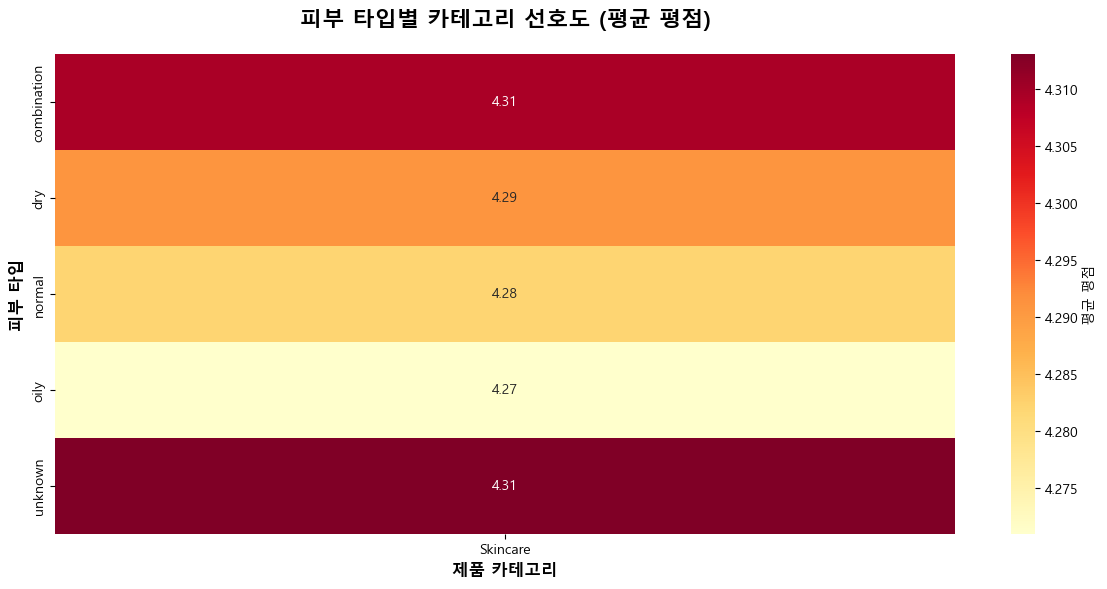


💡 해석:
   - 색이 진할수록 해당 피부 타입이 그 카테고리 제품에 높은 평점을 줌
   - 자신의 피부 타입에서 색이 진한 카테고리 제품을 추천받으면 만족도가 높을 가능성이 큼



In [17]:
# ============================================================
# 6-1. 피부 타입별 선호 카테고리 시각화
# ============================================================

print("📊 피부 타입별 선호 카테고리 분석\n")

# 피부 타입과 제품 정보를 결합
reviews_with_products = reviews_df.merge(
    products_df[['product_id', 'primary_category']],
    on='product_id',
    how='left'
)

# 피부 타입별 카테고리별 평균 평점 계산
skin_category_rating = reviews_with_products.groupby(
    ['skin_type', 'primary_category']
)['rating'].mean().reset_index()

# 상위 5개 카테고리만 선택
top_categories = products_df['primary_category'].value_counts().head(5).index
skin_category_rating = skin_category_rating[
    skin_category_rating['primary_category'].isin(top_categories)
]

# 피벗 테이블 생성
pivot_data = skin_category_rating.pivot(
    index='skin_type',
    columns='primary_category',
    values='rating'
)

# 히트맵 그리기
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': '평균 평점'})
plt.title('피부 타입별 카테고리 선호도 (평균 평점)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('제품 카테고리', fontsize=12, fontweight='bold')
plt.ylabel('피부 타입', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 해석:")
print("   - 색이 진할수록 해당 피부 타입이 그 카테고리 제품에 높은 평점을 줌")
print("   - 자신의 피부 타입에서 색이 진한 카테고리 제품을 추천받으면 만족도가 높을 가능성이 큼")
print("\n" + "="*60)


📊 가격대별 평점 분포 분석



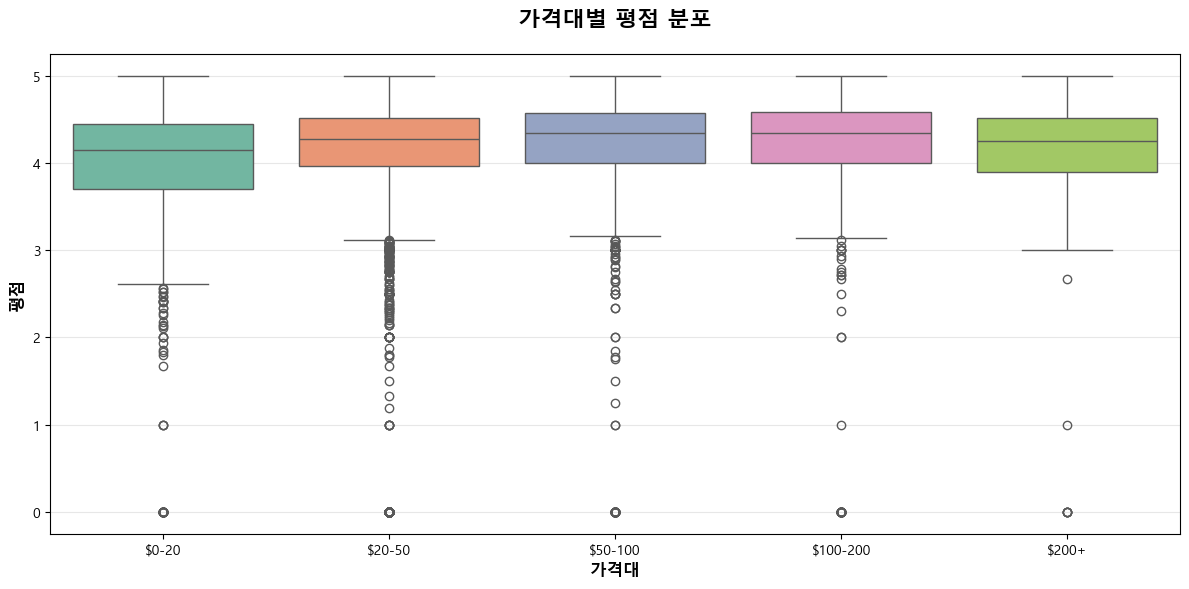


📊 가격대별 평균 평점:

             평균 평점  제품 수
price_range             
$0-20         3.95  1487
$20-50        4.08  4534
$50-100       4.09  1575
$100-200      4.04   723
$200+         4.06   174

💡 해석:
   - 가격이 높다고 항상 평점이 높은 것은 아님
   - 중가 제품($20-100)에서도 고평점 제품을 많이 찾을 수 있음



In [18]:
# ============================================================
# 6-2. 가격대별 평점 분포 시각화
# ============================================================

print("\n📊 가격대별 평점 분포 분석\n")

# 가격 구간 생성
products_df['price_range'] = pd.cut(
    products_df['price_usd'],
    bins=[0, 20, 50, 100, 200, 500],
    labels=['$0-20', '$20-50', '$50-100', '$100-200', '$200+']
)

# 박스플롯으로 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(data=products_df, x='price_range', y='rating', palette='Set2')
plt.title('가격대별 평점 분포', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('가격대', fontsize=12, fontweight='bold')
plt.ylabel('평점', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 가격대별 통계
print("\n📊 가격대별 평균 평점:\n")
price_stats = products_df.groupby('price_range').agg({
    'rating': 'mean',
    'product_id': 'count'
}).round(2)
price_stats.columns = ['평균 평점', '제품 수']
print(price_stats)

print("\n💡 해석:")
print("   - 가격이 높다고 항상 평점이 높은 것은 아님")
print("   - 중가 제품($20-100)에서도 고평점 제품을 많이 찾을 수 있음")
print("\n" + "="*60)

## 7️⃣ 요약 및 결론

---

### 🎓 이번 노트북에서 배운 내용

1. **추천 시스템의 개념**
   - 콘텐츠 기반 필터링: 제품의 특성을 분석하여 비슷한 제품 추천
   - 협업 필터링: 비슷한 사용자들의 선호도를 바탕으로 추천

2. **4가지 추천 시스템 구현**
   - ✅ 제품 유사도 기반 추천 (TF-IDF + 코사인 유사도)
   - ✅ 피부 타입 기반 추천 (사용자 특성 활용)
   - ✅ 브랜드 기반 추천 (인기도 분석)
   - ✅ 가격대 기반 추천 (가성비 분석)

3. **핵심 기술**
   - TF-IDF: 텍스트를 숫자로 변환하여 중요한 단어 추출
   - 코사인 유사도: 두 벡터(제품) 간의 유사도 계산
   - 데이터 집계 및 필터링: groupby, merge 등 활용

---

### 💡 추천 시스템 활용 팁

1. **여러 추천 방법을 조합하세요**
   - 예: 내 피부 타입 + 원하는 가격대 + 좋아하는 브랜드 조합

2. **리뷰 수가 적은 제품은 주의하세요**
   - min_reviews 파라미터로 최소 리뷰 수를 조정
   - 리뷰가 많을수록 평점이 신뢰할 만함

3. **평점만 보지 말고 추천 비율도 확인하세요**
   - 평점이 4.5지만 추천 비율이 60%인 제품보다
   - 평점이 4.3이지만 추천 비율이 90%인 제품이 더 안전할 수 있음

4. **실제 구매 전 리뷰를 읽어보세요**
   - 추천 시스템은 참고용이며, 최종 결정은 리뷰를 읽고 판단

---

### 🚀 다음 단계

- **06_ml_review_helpfulness.ipynb**: 어떤 리뷰가 도움이 되는지 예측하기
  - 리뷰 텍스트와 특성을 분석하여 유용성 점수 예측
  - 좋은 리뷰를 작성하는 방법 학습

---

### ✅ 체크리스트

- [ ] TF-IDF가 무엇인지 이해했나요?
- [ ] 코사인 유사도의 개념을 이해했나요?
- [ ] 4가지 추천 시스템을 모두 실행해봤나요?
- [ ] 내 피부 타입에 맞는 제품 추천을 받아봤나요?
- [ ] 원하는 가격대의 제품을 찾아봤나요?

---

**수고하셨습니다! 🎉**

이제 여러분은 실전 추천 시스템을 만들 수 있습니다!